# Week 1: Regression
## Count Regression on the Number
referred to: https://www.kaggle.com/code/andrewdk1123/count-regression-on-the-number-of-bicycles/notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2

## 데이터 로드

In [8]:
bicycles = pd.read_csv("/nyc-east-river-bicycle-counts.csv")

In [9]:
print(bicycles.describe())

       Unnamed: 0  High Temp (°F)  Low Temp (°F)  Brooklyn Bridge  \
count  210.000000      210.000000     210.000000       210.000000   
mean   104.500000       60.580000      46.413333      2269.633333   
std     60.765944       11.183223       9.522796       981.237786   
min      0.000000       39.900000      26.100000       504.000000   
25%     52.250000       55.000000      44.100000      1447.000000   
50%    104.500000       62.100000      46.900000      2379.500000   
75%    156.750000       68.000000      50.000000      3147.000000   
max    209.000000       81.000000      66.000000      3871.000000   

       Manhattan Bridge  Williamsburg Bridge  Queensboro Bridge         Total  
count        210.000000           210.000000         210.000000    210.000000  
mean        4049.533333          4862.466667        3352.866667  14534.500000  
std         1704.731356          1814.039499        1099.254419   5569.173496  
min          997.000000          1440.000000        1306.0

In [10]:
# 요일로 변환
bicycles['Day'] = pd.to_datetime(bicycles['Date']).dt.day_name()
bicycles['Day'] = pd.Categorical(bicycles['Day'], categories=["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])

In [11]:
print(bicycles['Day'].head())

0      Friday
1    Saturday
2      Sunday
3      Monday
4     Tuesday
Name: Day, dtype: category
Categories (7, object): ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                         'Saturday']


## EDA

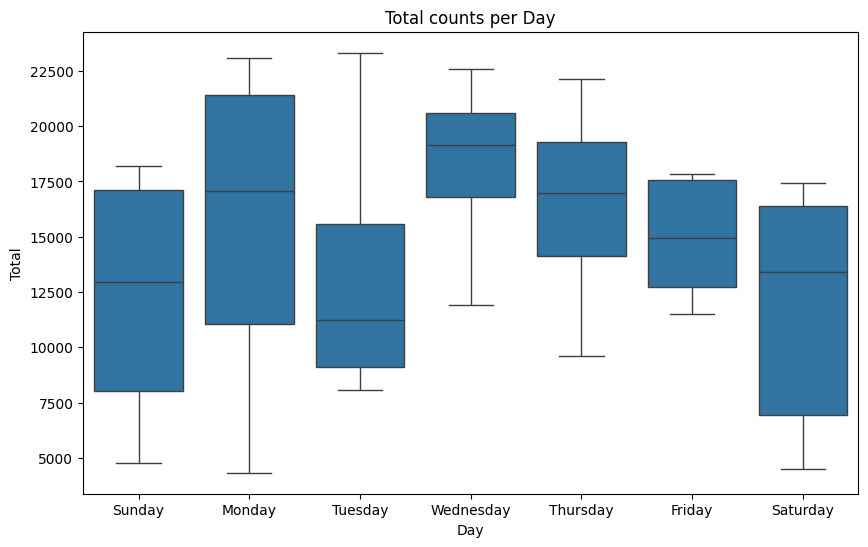

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Day', y='Total', data=bicycles)
plt.title('Total counts per Day')
plt.show()

In [14]:
print(bicycles['Precipitation'].unique())

['0.01' '0.15' '0.09' '0.47 (S)' '0' '0.2' 'T' '0.16' '0.24' '0.05']


In [15]:
# 날씨 변수 이진 변환
bicycles['weather'] = np.where(bicycles['Precipitation'] == "0", "sunny", "rain")
bicycles['weather'] = pd.Categorical(bicycles['weather'], categories = ["sunny", "rain"], ordered = True)
print(bicycles['weather'].value_counts())

weather
sunny    119
rain      91
Name: count, dtype: int64


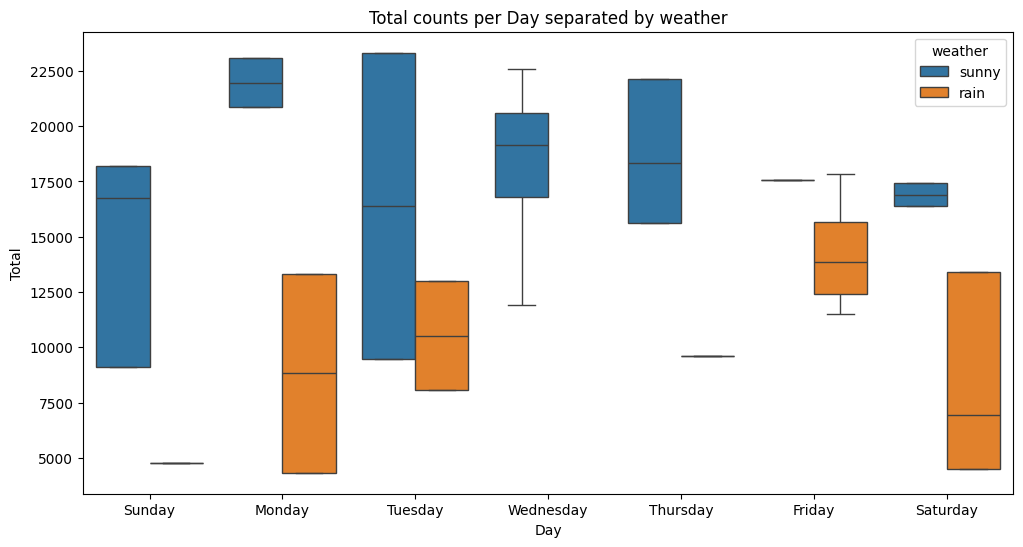

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Day', y='Total', hue='weather', data=bicycles)
plt.title('Total counts per Day separated by weather')
plt.show()

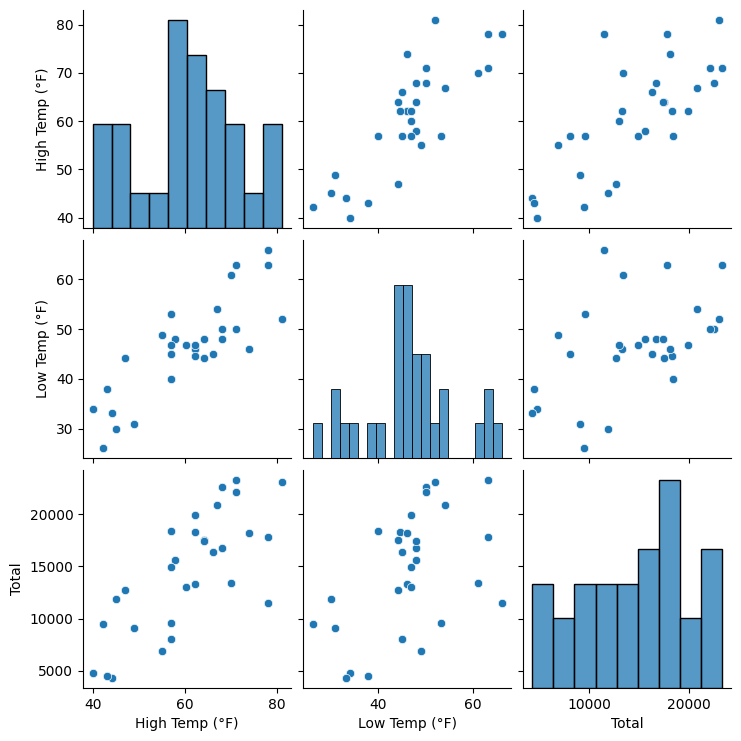

In [17]:
sns.pairplot(bicycles[['High Temp (°F)', 'Low Temp (°F)', 'Total']])

High Temp와 Low Temp의 상관관계 보임

In [18]:
# 변수 이름 사용하기 편하게 바꾸기
bicycles.rename(columns={'High Temp (°F)': 'H_Temp', 'Low Temp (°F)': 'L_Temp'}, inplace=True)

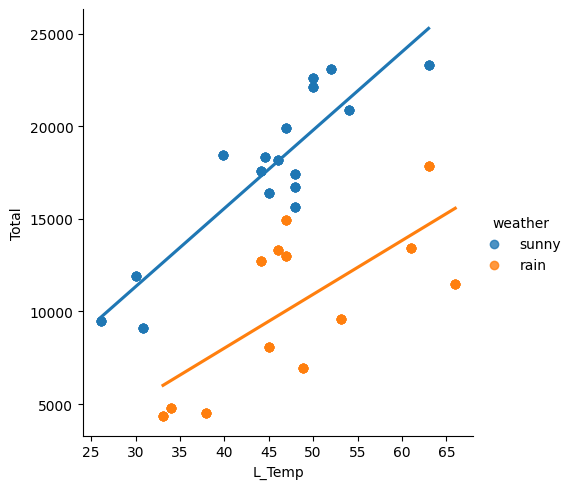

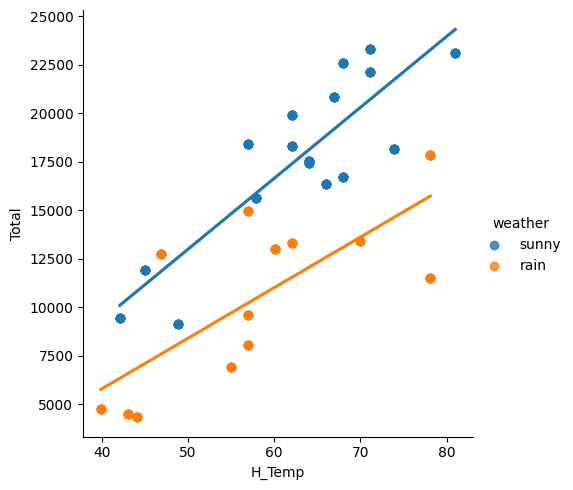

In [19]:
# 산점도 및 회귀선 plotting
sns.lmplot(x='L_Temp', y='Total', hue='weather', data=bicycles, ci=None)
sns.lmplot(x='H_Temp', y='Total', hue='weather', data=bicycles, ci=None)
plt.show()

온도에 따른 자전거 대여 횟수의 명확한 차이 없음

## Possion Regression

In [21]:
poisson_model = smf.glm(formula='Total ~ H_Temp + L_Temp + weather*Day', data=bicycles, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                  210
Model:                            GLM   Df Residuals:                      195
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -35439.
Date:                Wed, 03 Jul 2024   Deviance:                       68499.
Time:                        08:06:35   Pearson chi2:                 6.61e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

## Negative Binomial Regression

In [22]:
nb_model1 = smf.glm(formula='Total ~ H_Temp + L_Temp + weather*Day', data=bicycles, family=sm.families.NegativeBinomial()).fit()
print(nb_model1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                  210
Model:                            GLM   Df Residuals:                      195
Model Family:        NegativeBinomial   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2205.6
Date:                Wed, 03 Jul 2024   Deviance:                       6.0537
Time:                        08:08:13   Pearson chi2:                     5.50
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1503
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


잔차 deviance에 대한 카이제곱 검정

In [23]:
p_value = chi2.sf(nb_model1.deviance, nb_model1.df_resid)
print(f'P-value for model fit: {p_value}')

P-value for model fit: 1.0


p-값이 크게 나옴 -> 모델 적합도 낮음

In [24]:
# Low temp 제외한 모델
nb_model2 = smf.glm(formula='Total ~ H_Temp + weather*Day', data=bicycles, family=sm.families.NegativeBinomial()).fit()
print(nb_model2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                  210
Model:                            GLM   Df Residuals:                      196
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2205.8
Date:                Wed, 03 Jul 2024   Deviance:                       6.3963
Time:                        08:10:43   Pearson chi2:                     5.91
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1489
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


nb_model1, nb_model2 간 deviance 차이에 대한 카이제곱 검정

In [27]:
deviance_diff = nb_model2.deviance - nb_model1.deviance
p_value_diff = chi2.sf(deviance_diff, 1)
print(f'P-value for deviance difference: {p_value_diff}')

P-value for deviance difference: 0.5583293316093536


p-값 > 0.05 -> 두 모델의 차이 유의미하지 않음

nb_model2의 deviance에 대한 카이제곱 검정

In [29]:
p_value_nb2 = chi2.sf(nb_model2.deviance, nb_model2.df_resid)
print(f'P-value for model fit (nb_model2): {p_value_nb2}')

P-value for model fit (nb_model2): 1.0


## Prediction

In [31]:
temp = np.arange(bicycles['H_Temp'].min(), bicycles['H_Temp'].max(), 0.01)
new_data = pd.DataFrame({
    'Day': ['Sunday'] * len(temp),
    'weather': ['sunny'] * len(temp),
    'H_Temp': temp
})

In [32]:
new_data['predictions'] = nb_model2.predict(new_data)

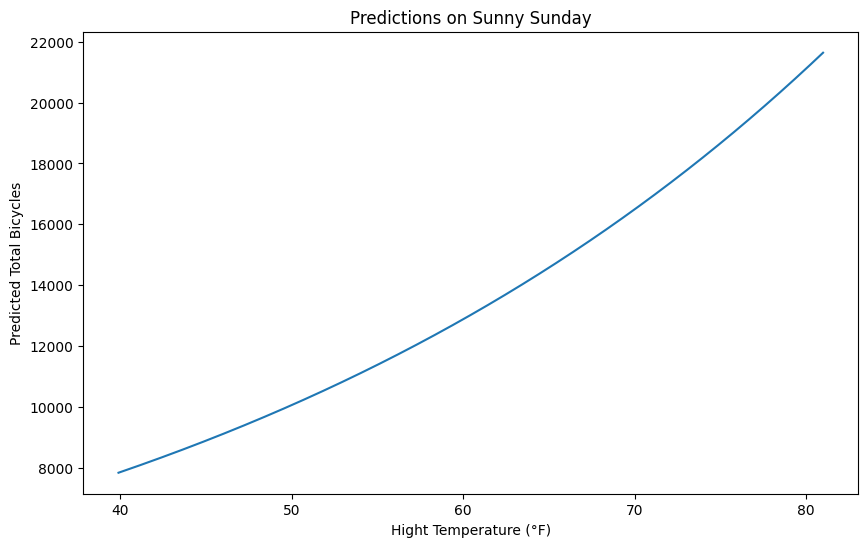

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(new_data['H_Temp'], new_data['predictions'])
plt.title('Predictions on Sunny Sunday')
plt.xlabel('Hight Temperature (°F)')
plt.ylabel('Predicted Total Bicycles')
plt.show()